In [33]:
import numpy as np
import pandas as pd

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn import preprocessing

In [35]:
train = pd.read_csv("data/train_advanced.csv")
test = pd.read_csv("data/test_advanced.csv")
sample = pd.read_csv("data/sample_submission.csv")

# Exploratory Data Analysis

In [38]:
train = train.drop(columns=['Location', 'Category', 'Branding'])

In [39]:
train.head()

,Date,Store,Item,Sales,Average Rating
0,1/1/2017,KMart,1,13,2.8
1,1/2/2017,KMart,1,11,1.4
2,1/3/2017,KMart,1,14,1.8
3,1/4/2017,KMart,1,13,1.3
4,1/5/2017,KMart,1,10,2.9


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821000 entries, 0 to 820999
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            821000 non-null  object 
 1   Store           821000 non-null  object 
 2   Item            821000 non-null  int64  
 3   Sales           821000 non-null  int64  
 4   Average Rating  821000 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 31.3+ MB


## Date

In [41]:
train.Date=pd.to_datetime(train.Date,format='%m/%d/%Y')
train.Date.dtypes
train.Date.unique()

array(['2017-01-01T00:00:00.000000000', '2017-01-02T00:00:00.000000000',
       '2017-01-03T00:00:00.000000000', ...,
       '2021-06-28T00:00:00.000000000', '2021-06-29T00:00:00.000000000',
       '2021-06-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [42]:
train['year'] = pd.DatetimeIndex(train['Date']).year
train['month'] = pd.DatetimeIndex(train['Date']).month
train['day'] = pd.DatetimeIndex(train['Date']).day

In [43]:
len(train[train["year"]==2017])

182500

In [44]:
train.head()

,Date,Store,Item,Sales,Average Rating,year,month,day
0,2017-01-01,KMart,1,13,2.8,2017,1,1
1,2017-01-02,KMart,1,11,1.4,2017,1,2
2,2017-01-03,KMart,1,14,1.8,2017,1,3
3,2017-01-04,KMart,1,13,1.3,2017,1,4
4,2017-01-05,KMart,1,10,2.9,2017,1,5


In [47]:
train.Store.unique()

array(['KMart', 'Target', 'Coles', 'Woolies', 'BigW', 'Aldi',
       'Asian SuperMart', 'Big Savers', 'Costco', 'SupaIGA'], dtype=object)

In [18]:
# one hot encoding for store
train_storedummy=pd.get_dummies(train.Store,prefix="Store")
train=pd.concat([train,train_storedummy],axis=1)
train=train.drop(columns=["Store"])

In [56]:
train = train.set_index(["Date"])
train

,Store,Item,Sales,Average Rating,year,month,day
Date,,,,,,,
2017-01-01,KMart,1,13,2.8,2017,1,1
2017-01-02,KMart,1,11,1.4,2017,1,2
2017-01-03,KMart,1,14,1.8,2017,1,3
2017-01-04,KMart,1,13,1.3,2017,1,4
2017-01-05,KMart,1,10,2.9,2017,1,5
...,...,...,...,...,...,...,...
2021-06-26,SupaIGA,50,82,0.4,2021,6,26
2021-06-27,SupaIGA,50,83,0.8,2021,6,27
2021-06-28,SupaIGA,50,91,2.0,2021,6,28


In [57]:
grouped_items = train.groupby(train.Item)

items = range(1, 51)

dataframes = {}

for item in items:
    dataframes[item] = grouped_items.get_group(item)

dfs = {}

for item in items:
    
    df = dataframes[item]
    
    grouped_location = df.groupby(df.Store)
    
    dfs[item] = {}
    for store in train.Store.unique():
        dfs[item][store] = grouped_location.get_group(store)

      
dfs[2]["Coles"]

,Store,Item,Sales,Average Rating,year,month,day
Date,,,,,,,
2017-01-01,Coles,2,43,3.1,2017,1,1
2017-01-02,Coles,2,27,3.1,2017,1,2
2017-01-03,Coles,2,38,3.1,2017,1,3
2017-01-04,Coles,2,35,3.1,2017,1,4
2017-01-05,Coles,2,47,3.1,2017,1,5
...,...,...,...,...,...,...,...
2021-06-26,Coles,2,79,3.1,2021,6,26
2021-06-27,Coles,2,80,3.1,2021,6,27
2021-06-28,Coles,2,90,3.1,2021,6,28


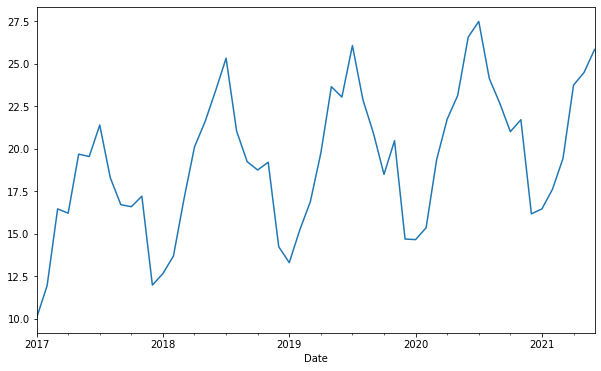

In [63]:

import seaborn as sns

dfs[16]["Aldi"].Sales.resample('MS').mean().plot() # MS implies Month Starting

ty = dfs[16]["Aldi"].Sales.resample('MS').mean()


# ARIMA

In [104]:
# Param optimisation

import statsmodels.api as sm
import itertools
import math

ty = dfs[1]["Coles"].Sales.resample('MS').mean()

# p = d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# lowest = {"order": (0,0,0), "param_seasonal": (0,0,0,12), "AIC": math.inf}
# for order in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(ty,order=order,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
#             results = mod.fit()
#             if results.aic < lowest["AIC"]:
#                 lowest["order"] = order
#                 lowest["param_seasonal"] = param_seasonal
#                 lowest["AIC"] = results.aic
#         except:
#             continue

# print(lowest)

# mod = sm.tsa.statespace.SARIMAX(ty,
#                                 order=lowest["order"],
#                                 seasonal_order=lowest["param_seasonal"],
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)

mod = sm.tsa.statespace.SARIMAX(ty,
                                order=(0,1,1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

In [105]:
mod = sm.tsa.statespace.SARIMAX(ty,
                                order=lowest["order"],
                                seasonal_order=lowest["param_seasonal"],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
# print(results.summary().tables[1])

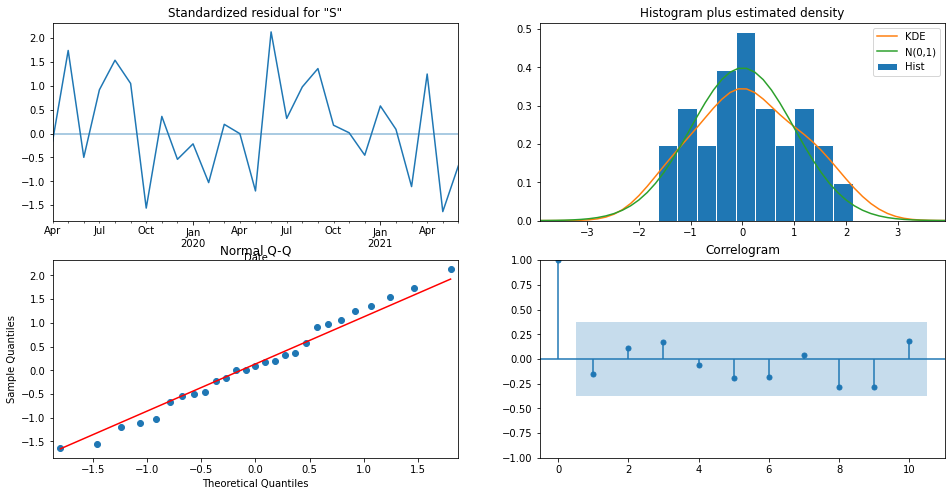

In [67]:
# results.plot_diagnostics(figsize=(16, 8))
# plt.show()

In [76]:
# test.Date=pd.to_datetime(test.Date,format='%m/%d/%Y')

In [106]:
test_y = test.groupby(test.Item).get_group(1).groupby(test.Store).get_group("Coles").Date
list(test_y)[0]
list(test_y)[-1]

Timestamp('2021-12-31 00:00:00')

In [107]:
pred = results.get_prediction(start=list(test_y)[0], end=list(test_y)[-1])
# pred = results.get_prediction(test.groupby(test.Item).get_group(16).groupby(test.Store).get_group("Aldi").Date, dynamic=False)
pred.predicted_mean

2021-07-01    36.248312
2021-08-01    32.730598
2021-09-01    30.532939
2021-10-01    28.187573
2021-11-01    29.939002
2021-12-01    22.976544
2022-01-01    21.794667
Freq: MS, Name: predicted_mean, dtype: float64

In [98]:
pred.conf_int()

,lower Sales,upper Sales
2021-07-01,27.186006,30.054715
2021-08-01,23.658247,26.526957
2021-09-01,21.837794,24.706504
2021-10-01,20.250357,23.119066
2021-11-01,21.509032,24.377741
2021-12-01,16.031603,18.900312
2022-01-01,15.837876,18.710139
